In [2]:
!pip install roboflow --quiet
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.11 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.2 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.8.1 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from roboflow import Roboflow
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models
from PIL import Image, ImageDraw,ImageFont
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
rf = Roboflow(api_key="TUbjzyIipJTrvQqlV7Tv")
project = rf.workspace("minor-project-i54la").project("segment_shoe")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to segment_shoe-2 in yolov8:: 100%|██████████| 6252/6252 [00:01<00:00, 5887.75it/s]


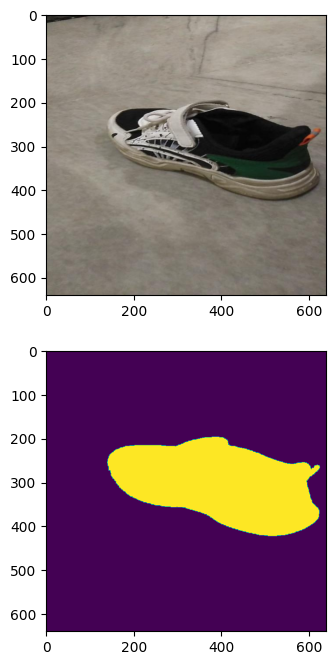

In [5]:
# set image and annotation paths
image_path = "/kaggle/working/segment_shoe-2/train/images/0-02-03-f3bb429f4a63ea423e46c3337a5330f871a3bffbf6c609a4e59e549a4703c6d2_db2922c643eeeddf_0_jpg.rf.1fa623e91fbc5833ad6007fcf2a9f3ae.jpg"
annotation_path = "/kaggle/working/segment_shoe-2/train/labels/0-02-03-f3bb429f4a63ea423e46c3337a5330f871a3bffbf6c609a4e59e549a4703c6d2_db2922c643eeeddf_0_jpg.rf.1fa623e91fbc5833ad6007fcf2a9f3ae.txt"

# open image and resize
img = Image.open(image_path)
img = img.resize((640, 640))

# Helper functions start here

def maskVisualize(image, mask):
    fontsize = 18
    f, ax = plt.subplots(2, 1, figsize=(8, 8))
    ax[0].imshow(image)
    ax[1].imshow(mask)

def generate_points(annotation_path=''):
    labels = []  # this will store labels
    # assuming that the image is of dimension (640,640) and then annotated
    with open(annotation_path, "r") as file:
        points = []
        for line in file:
            label, lis = line.split()[0], line.split()[1:]
            labels.append(label)
            lis = list(map(float, lis))
            for i in range(len(lis)):
                lis[i] = int(lis[i] * 640)
            newlis = []
            i = 0
            while (i < len(lis)):
                newlis.append((lis[i], lis[i + 1]))
                i += 2
            points.append(newlis)
    return labels, points

def convert_boundary_to_mask_array(labels, points, show=0):
    mask = Image.new("L", (640, 640), 0)
    draw = ImageDraw.Draw(mask)
    for i, boundary_coords in enumerate(points):
        draw.polygon(boundary_coords, fill=1)

    mask_array = np.array(mask) * 255
    return mask_array

def generate_mask(annotation_path='', show=0):
    labels, points = generate_points(annotation_path)
    mask_array = convert_boundary_to_mask_array(labels, points, show)
    return mask_array

# Helper functions end here

# generate mask and visualize
mask_array = generate_mask(annotation_path=annotation_path, show=1)
maskVisualize(np.array(img), mask_array)


In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
class ShoesDataset(Dataset):

    def __init__(self, filename_path, transform):
        super().__init__()
        self._filename_shoes = [filename_path + '/' + path \
                                for path in os.listdir(filename_path)]
        self._transforms = transform

    def __getitem__(self, index):
        name = self._filename_shoes[index]
        image = Image.open(name)

        mask_name = name.replace('images/', 'labels/').replace('.jpg', '.txt')
        mask = generate_mask(mask_name)
        if self._transforms is not None:
            image = self._transforms(image)
            mask = self._transforms(mask)

        background = (mask==0).float()
        final_mask = torch.cat([background, mask], dim=0)

        return image, final_mask

    def __len__(self):
        return len(self._filename_shoes)-1

In [8]:
train_dataset = ShoesDataset('/kaggle/working/segment_shoe-2/train/images', transform=train_transform)
image, mask = train_dataset[0]

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=2)
val_dataset = ShoesDataset('/kaggle/working/segment_shoe-2/valid/images', transform=train_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1)

In [4]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['background', 'shoes']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=2, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 244MB/s] 


In [5]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

32521250

In [11]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 25

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
    model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)


In [12]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 339/339 [00:12<00:00, 26.39it/s, dice_loss - 0.01676, iou_score - 0.9792]
Model saved!

Epoch: 1
valid: 100%|██████████| 339/339 [00:12<00:00, 26.40it/s, dice_loss - 0.02038, iou_score - 0.9649]

Epoch: 2
valid: 100%|██████████| 339/339 [00:12<00:00, 26.19it/s, dice_loss - 0.01823, iou_score - 0.9672]

Epoch: 3
valid: 100%|██████████| 339/339 [00:12<00:00, 26.11it/s, dice_loss - 0.04912, iou_score - 0.9156]

Epoch: 4
valid: 100%|██████████| 339/339 [00:12<00:00, 26.46it/s, dice_loss - 0.01276, iou_score - 0.9764] 

Epoch: 5
valid: 100%|██████████| 339/339 [00:12<00:00, 26.28it/s, dice_loss - 0.01428, iou_score - 0.9734] 

Epoch: 6
valid: 100%|██████████| 339/339 [00:12<00:00, 26.37it/s, dice_loss - 0.01374, iou_score - 0.9741] 

Epoch: 7
valid: 100%|██████████| 339/339 [00:12<00:00, 26.18it/s, dice_loss - 0.01139, iou_score - 0.9787] 

Epoch: 8
valid: 100%|██████████| 339/339 [00:12<00:00, 26.46it/s, dice_loss - 0.02163, iou_score - 0.9601]

Epoch: 9
v

In [14]:
images = os.listdir("/kaggle/working/segment_shoe-2/test/images/")

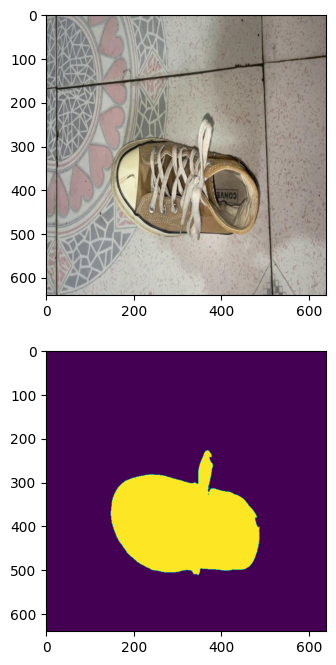

In [17]:
index = np.random.randint(len(images)-1)
path = f'/kaggle/working/segment_shoe-2/test/images/{images[index]}'
image = Image.open(path)
image_tensor = train_transform(image).unsqueeze(0).to(device)
mask = model(image_tensor)
maskVisualize(np.array(image), mask.cpu().detach().numpy()[0,1,:,:])

In [18]:
#25 epoch
test_dataset = ShoesDataset('/kaggle/working/segment_shoe-2/test/images', transform=train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

test_epoch = smp.utils.train.ValidEpoch(
                         model=model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 347/347 [00:13<00:00, 26.47it/s, dice_loss - 0.03475, iou_score - 0.9397]


In [71]:
#10epoch
test_dataset = ShoesDataset('/kaggle/working/segment_shoe-2/test/images', transform=train_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1)

test_epoch = smp.utils.train.ValidEpoch(
                         model=model,
                         loss=loss,
                         metrics=metrics,
                         device=DEVICE,
                         verbose=True
                      )

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 347/347 [00:12<00:00, 27.05it/s, dice_loss - 0.02527, iou_score - 0.9548]
